# Import Necessary Packages

In [247]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import glob
import matplotlib.pyplot as plt
import random

# Organize and PreProcess Images

In [326]:
# Makes new folders with training/validation data if they don't already exist
os.chdir('DS22/malaria-detection/cell_images')
if os.path.isdir('train/Uninfected') is False:
    os.makedirs('train/Uninfected')
    os.makedirs('train/Parasitized')
    os.makedirs('val/Uninfected')
    os.makedirs('val/Parasitized')
    for i in random.sample(glob.glob('Uninfected/*'), 9645):
        shutil.move(i, 'train/Uninfected')      
    for i in random.sample(glob.glob('Parasitized/*'), 9645):
        shutil.move(i, 'train/Parasitized')
    for i in random.sample(glob.glob('Uninfected/*'), 3984):
        shutil.move(i, 'val/Uninfected')        
    for i in random.sample(glob.glob('Parasitized/*'), 3984):
        shutil.move(i, 'val/Parasitized')

In [157]:
# Confirm correct sizes
print(len(os.listdir('train/Uninfected')))
print(len(os.listdir('train/Parasitized')))
print(len(os.listdir('val/Uninfected')))
print(len(os.listdir('val/Parasitized')))

9645
9645
3984
3984


In [308]:
train_path = 'train'
val_pth = 'val'
par = 'Parasitized'
un = 'Uninfected'

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_un = ImageDataGenerator(rescale=1/255)
test_par = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        classes = ['Uninfected', 'Parasitized'],
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')


val_generator = validation_datagen.flow_from_directory(
        val_pth, 
        classes = ['Uninfected', 'Parasitized'],
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

# LATER USED FOR EXAMPLES
test_uninfected = test_un.flow_from_directory(
    un,
    classes = ['Uninfected'],
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

test_parasitized = test_par.flow_from_directory(
    par,
    classes = ['Parasitized'],
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


Found 19290 images belonging to 2 classes.
Found 7968 images belonging to 2 classes.
Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.


In [236]:
imgs, labels = next(train_generator)

In [288]:
def showImages(images_arr, labels):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    r = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = labels[0 + r]
        if label == 0:
            title = 'Uninfected'
        else:
            title = 'Parasitized'
        ax.set_title(title, fontsize=20)
        r +=1
    plt.tight_layout(pad=0.4, )
    plt.show()

# Let's look at some example images:

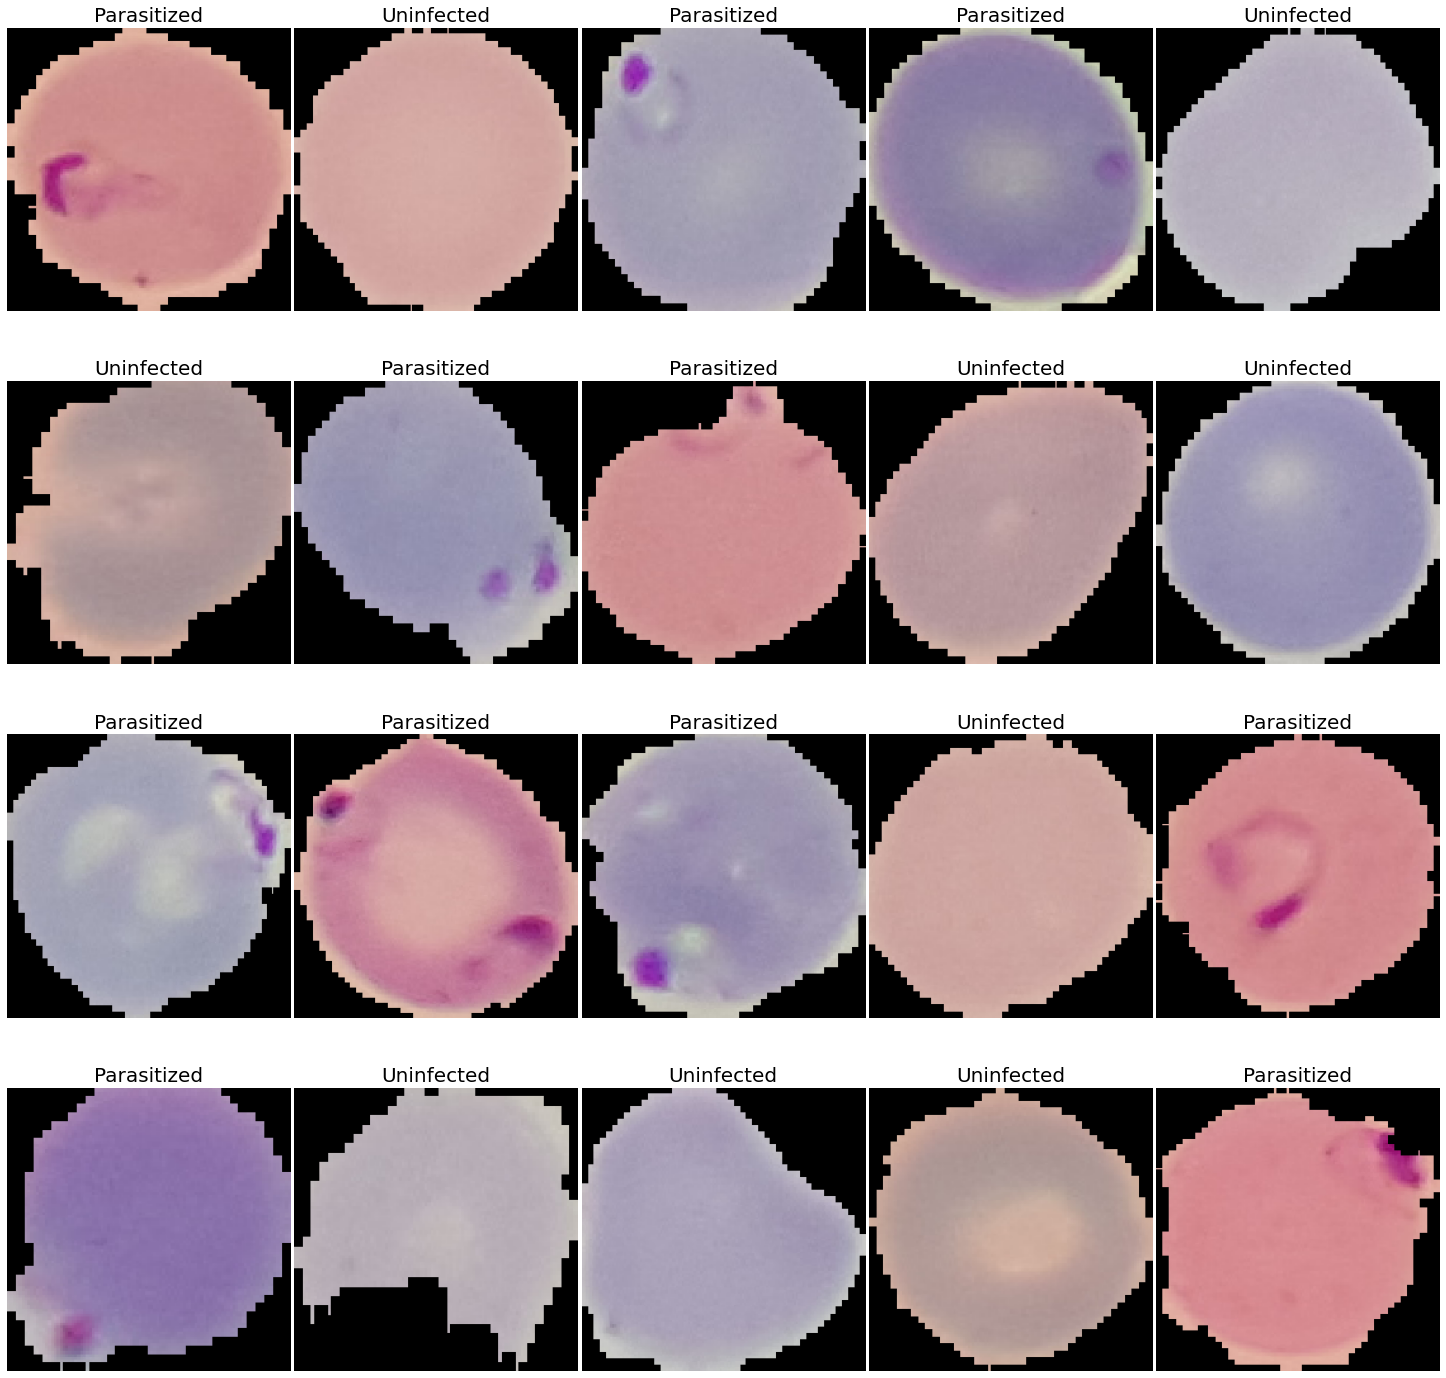

In [327]:
showImages(imgs, labels)

# Build Model

In [240]:
model = tf.keras.models.Sequential([Conv2D(input_shape = (224, 224, 3), filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    MaxPool2D(pool_size = (2,2), strides = 2),
                                    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    MaxPool2D(pool_size = (2,2), strides = 2),
                                    Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    MaxPool2D(pool_size = (2,2), strides = 2),
                                    Flatten(),
                                    Dense(1, activation='sigmoid')])

In [241]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)     

In [242]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [232]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [243]:
model = model.fit(train_generator,
                   steps_per_epoch=10,  
                   epochs=30,
                   verbose=1,
                   validation_data = val_generator,
                   validation_steps=10)

Epoch 1/30
10/10 [==============================] - 98s 10s/step - loss: 0.5569 - accuracy: 0.7500 - val_loss: 0.8994 - val_accuracy: 0.5100
Epoch 2/30
10/10 [==============================] - 97s 10s/step - loss: 0.5798 - accuracy: 0.7950 - val_loss: 0.4471 - val_accuracy: 0.9100
Epoch 3/30
10/10 [==============================] - 3617s 401s/step - loss: 0.5477 - accuracy: 0.7600 - val_loss: 0.7842 - val_accuracy: 0.5150
Epoch 4/30
10/10 [==============================] - 95s 10s/step - loss: 0.5597 - accuracy: 0.7300 - val_loss: 0.4971 - val_accuracy: 0.8450
Epoch 5/30
10/10 [==============================] - 138s 14s/step - loss: 0.5170 - accuracy: 0.7450 - val_loss: 0.6078 - val_accuracy: 0.7150
Epoch 6/30
10/10 [==============================] - 114s 12s/step - loss: 0.5800 - accuracy: 0.8000 - val_loss: 0.5229 - val_accuracy: 0.8450
Epoch 7/30
10/10 [==============================] - 119s 12s/step - loss: 0.5475 - accuracy: 0.7250 - val_loss: 0.5418 - val_accuracy: 0.8300
Epoch 8

In [246]:
model.evaluate(val_generator)

399/399 [==============================] - 989s 2s/step - loss: 0.5370 - accuracy: 0.9057


[0.536987841129303, 0.9057480096817017]

# Make Predictions

In [320]:
def showImagesPred(images_arr, labels, predictions):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    r = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = labels[0 + r]
        pred = predictions[0 + r]
        if pred == 0:
            title = 'Predicted Uninfected'
        else:
            title = 'Predicted Parasitized'
        ax.set_title(title, fontsize=15)
        r +=1
    plt.tight_layout(pad=0.4, )
    plt.show()

In [309]:
u_imgs, u_labels = next(test_uninfected)
p_imgs, p_labels = next(test_parasitized)

In [311]:
predicted_p = model.predict(x = test_parasitized)

In [312]:
predicted_u = model.predict(x = test_uninfected)

In [313]:
pred_images_p = np.round(predicted_p);
pred_images_u = np.round(predicted_u);

# Predictions for Examples Labeled Uninfected

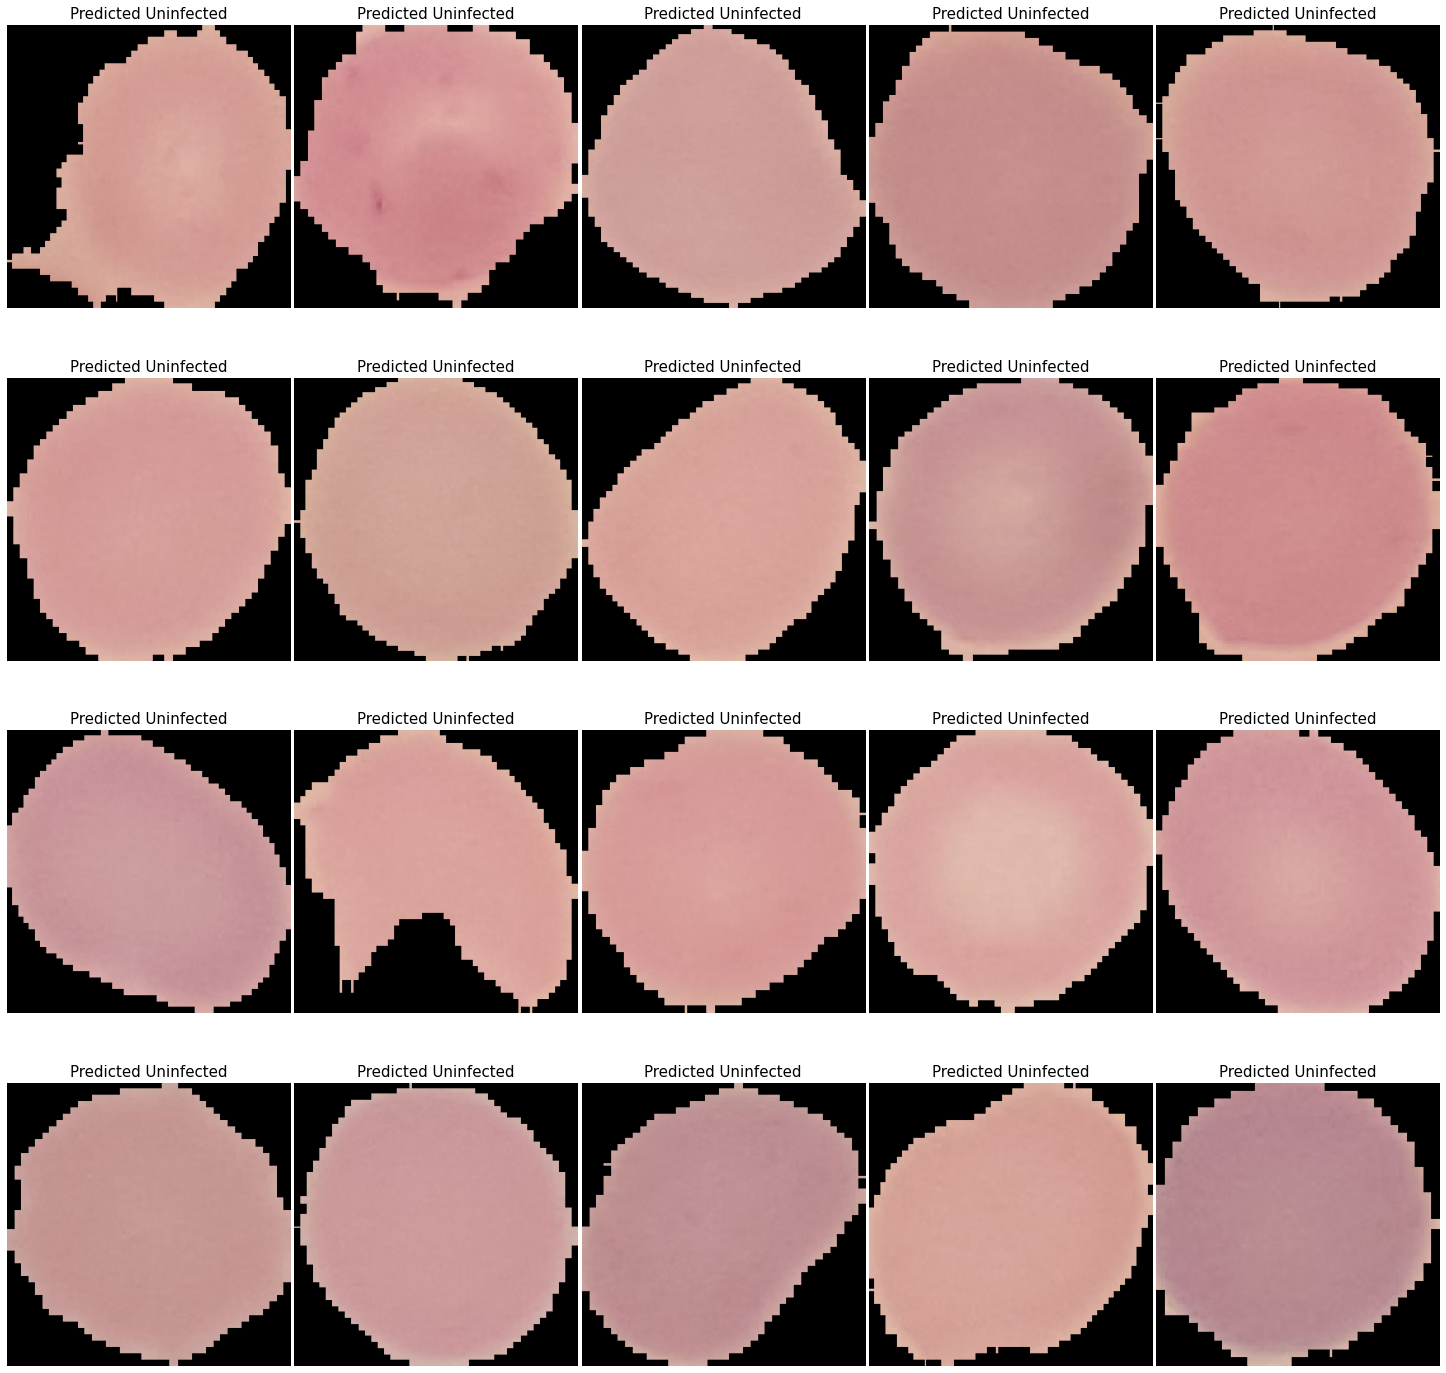

In [328]:
showImagesPred(u_imgs, u_labels, pred_images_u)

# Predictions for Examples Labeled Infected

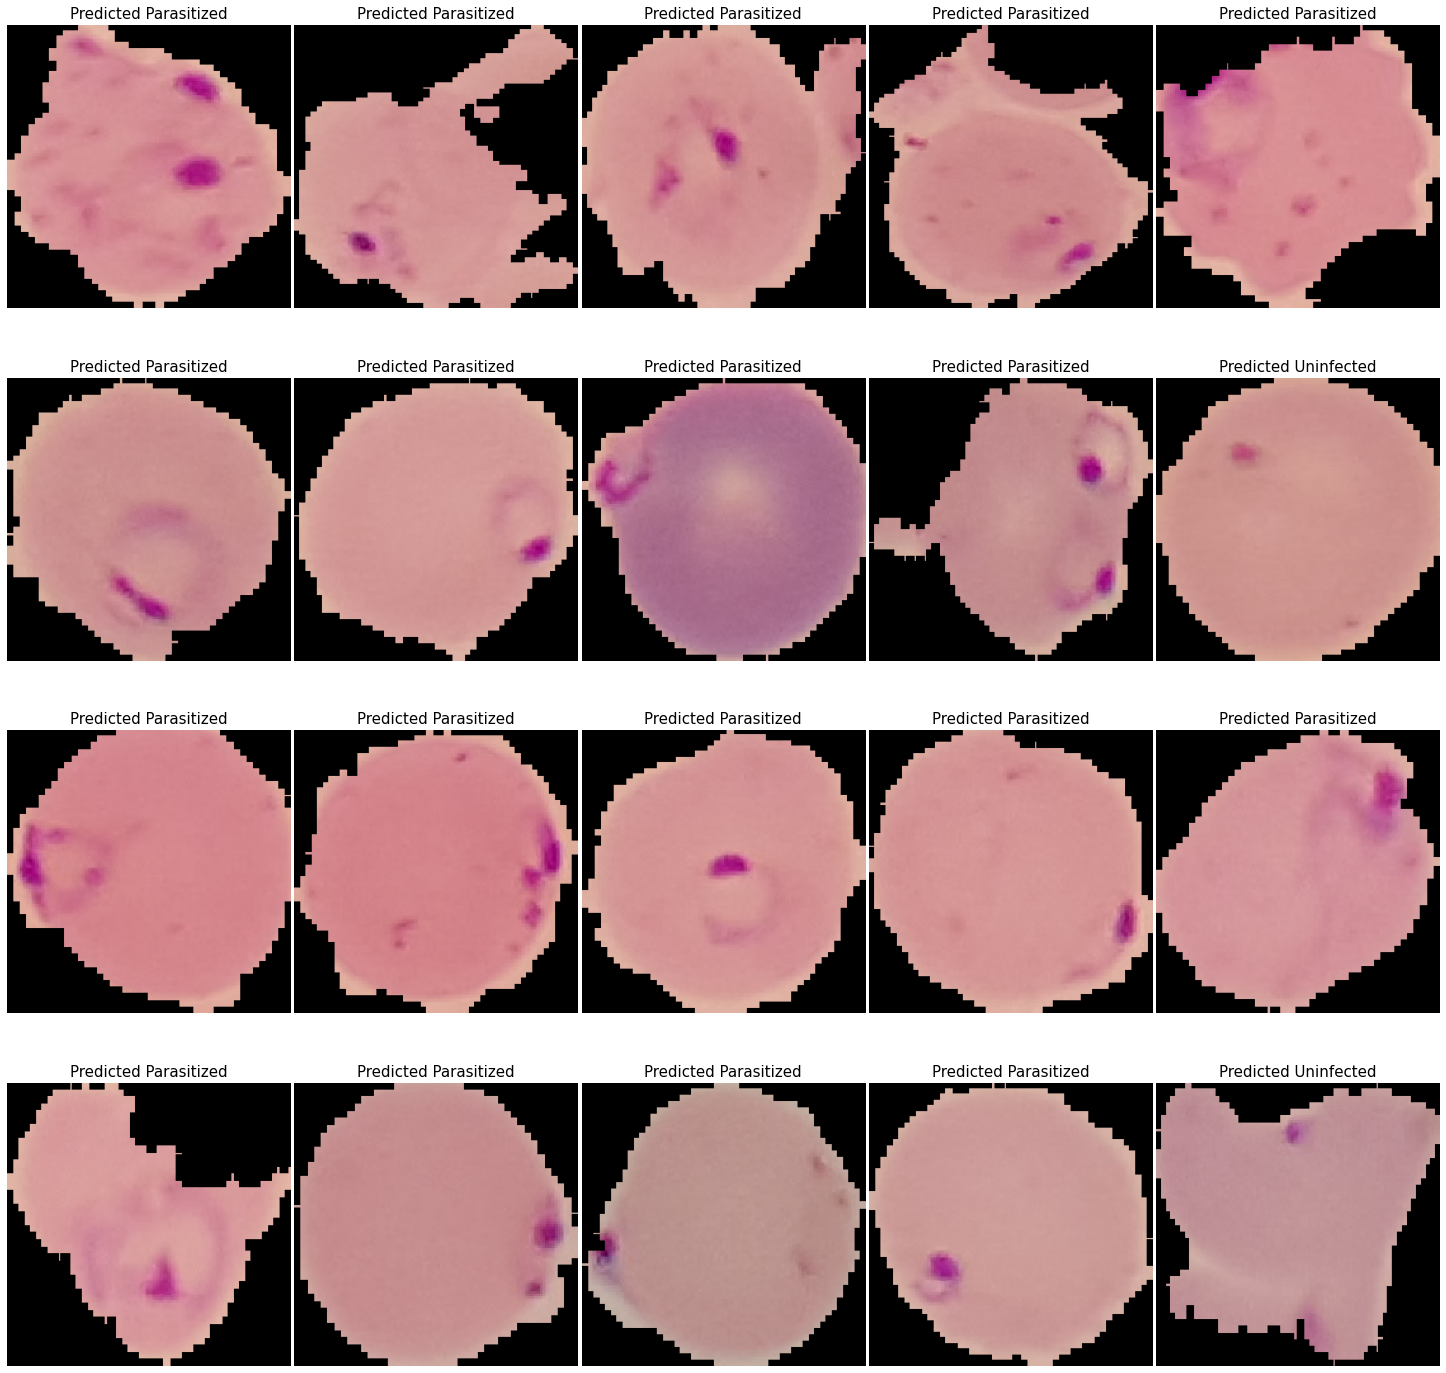

In [322]:
showImagesPred(p_imgs, p_labels, pred_images_p)